In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from scipy.linalg import svd
from scipy.interpolate import UnivariateSpline
import re

In [2]:
pulses = pd.read_excel('pulses.xlsx', dtype=np.float)

timecol = 'time (ps)'

# extract time colums and delet it
times = pulses[timecol].to_numpy()
pulses.drop(columns=[timecol], inplace=True)

# scale the fileds to maximum
field_ampl = pulses.abs().max().max()
pulses /= field_ampl

pulses.columns

Index(['f=0.4 THz', 'f=0.5 THz', 'f=0.6 THz', 'f=0.7 THz', 'f=0.8 THz',
       'f=0.9 THz', 'f=1.0 THz', 'f=1.1 THz', 'f=1.2 THz', 'f=2.0 THz'],
      dtype='object')

In [3]:
# extract numbers from the column names as str
omega = [
    re.search('[0-9]+.[0-9]+', _).group() for _ in pulses.columns
]

In [4]:
# extract the column corresponding to the largest frequency
largest_freq = pulses.columns[
    np.array(omega, dtype=np.float).argmax()
]
largest_freq

'f=2.0 THz'

In [5]:
"""
# using spline interpolation to add more time points
t_old = np.linspace(0, 1, times.size)
t_new = np.linspace(0, 1, 10 * times.size)

# redefining dataframe
pulses = pd.DataFrame({
    colname: UnivariateSpline(t_old, pulses[colname], s=0)(t_new) 
    for colname in pulses.columns
})

# redefining time array 
times = np.linspace(times[0], times[-1], len(pulses))
"""

'\n# using spline interpolation to add more time points\nt_old = np.linspace(0, 1, times.size)\nt_new = np.linspace(0, 1, 10 * times.size)\n\n# redefining dataframe\npulses = pd.DataFrame({\n    colname: UnivariateSpline(t_old, pulses[colname], s=0)(t_new) \n    for colname in pulses.columns\n})\n\n# redefining time array \ntimes = np.linspace(times[0], times[-1], len(pulses))\n'

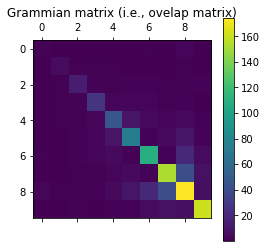

In [6]:
plt.matshow(np.abs(pulses.T @ pulses))
plt.colorbar()
plt.title("Grammian matrix (i.e., ovelap matrix)")
plt.show()

In [7]:
def plot_pulses(df):
    """
    Plot pulses saved in DataFrame dt
    """
    for colname in df.columns:        
        
        plt.plot(times, df[colname], label=colname)

    plt.ylabel('Nomrlized electric field')
    plt.xlabel(timecol)
    plt.legend(loc='right')

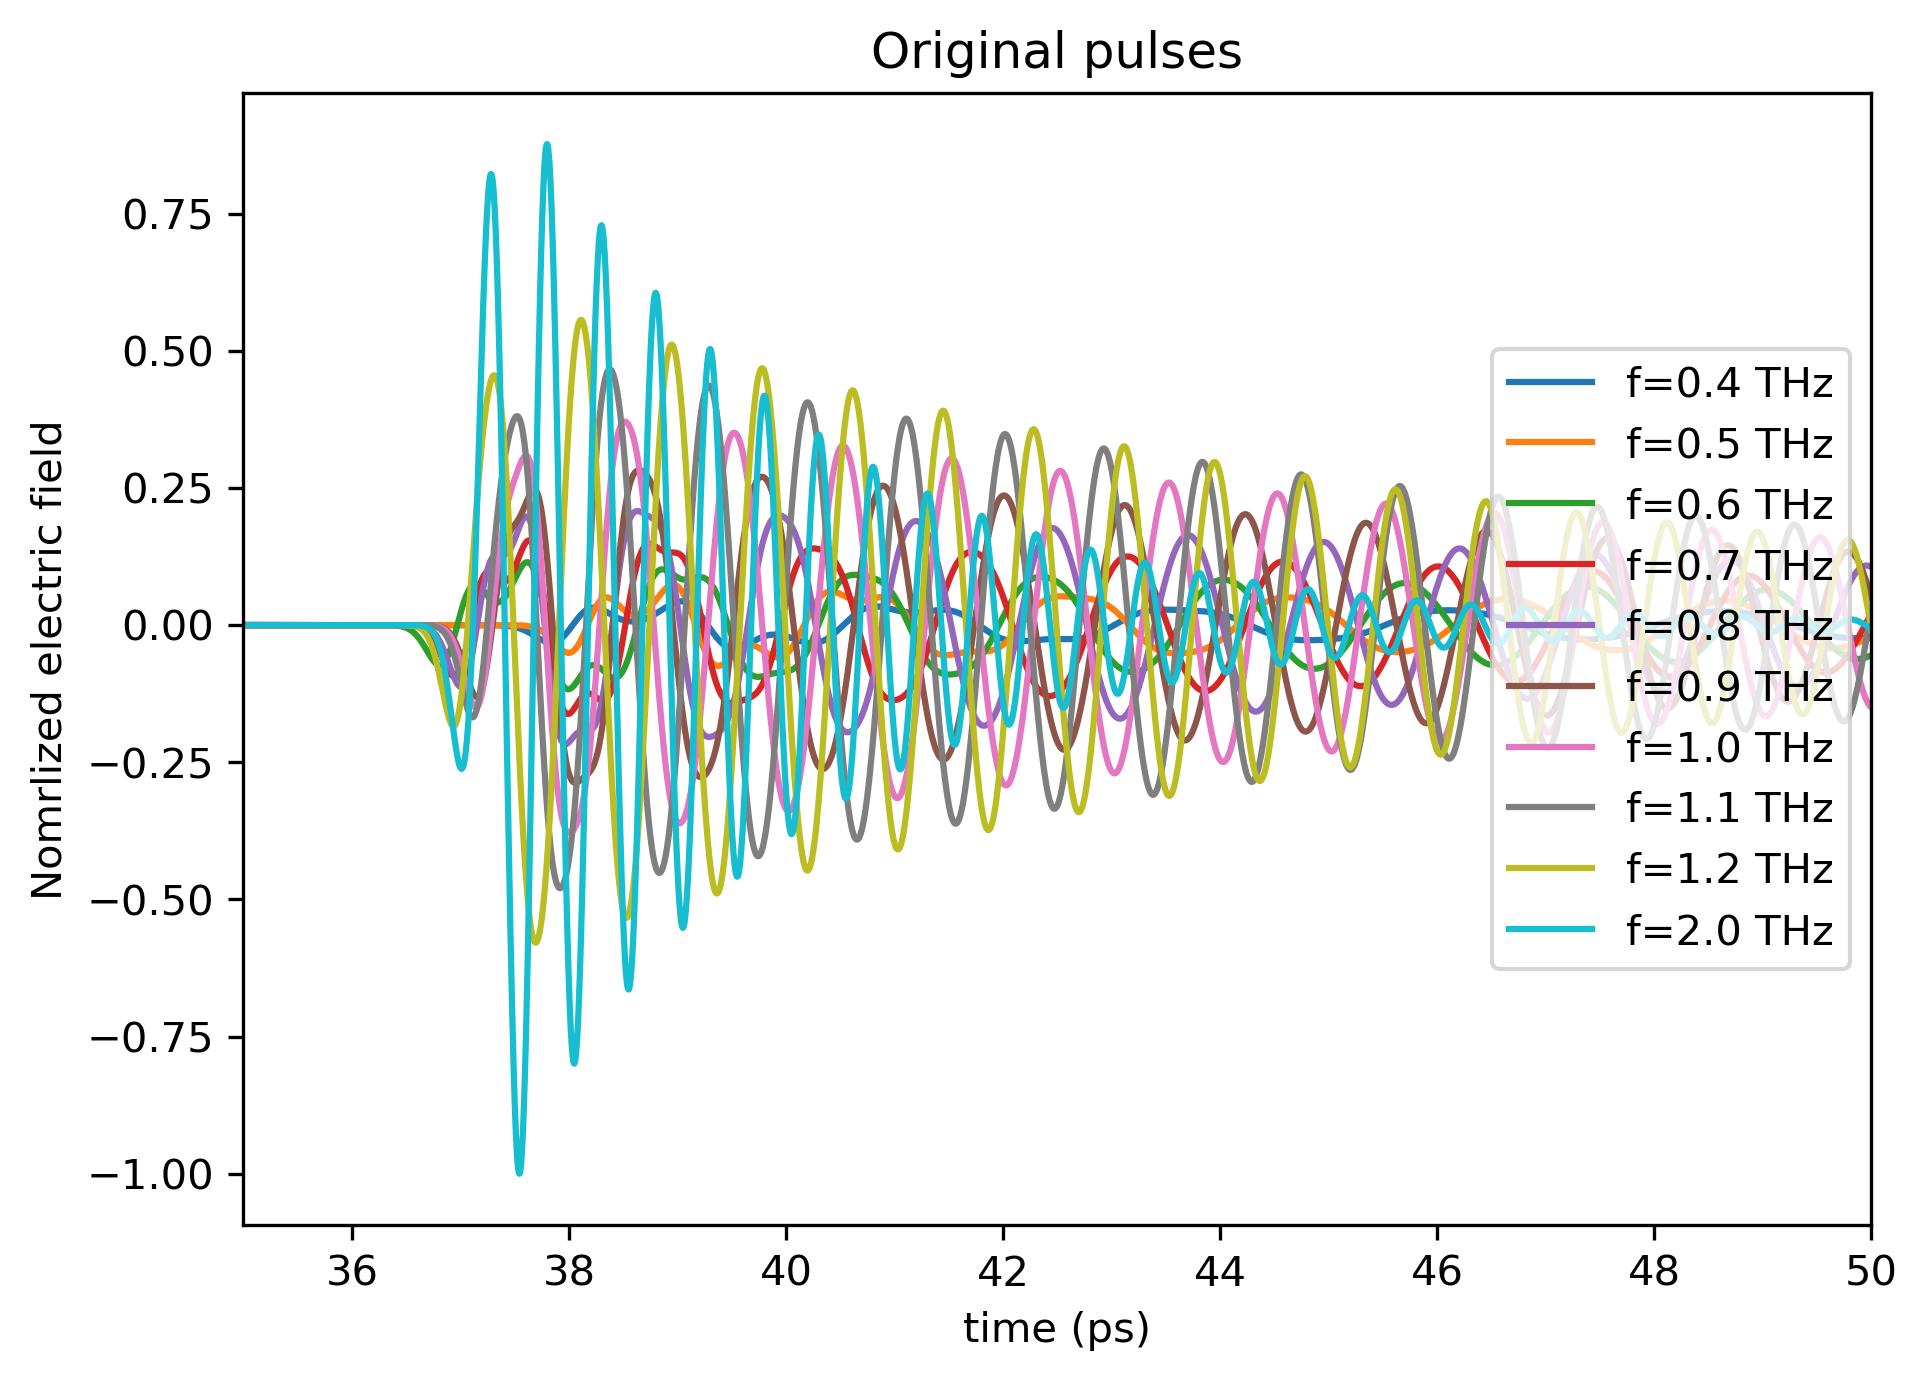

In [8]:
plt.figure(figsize=(7, 5), dpi=300)
plt.xlim([35, 50])
plt.title('Original pulses')
plot_pulses(pulses)
plt.savefig("original_pulses.pdf", transparent=True)
plt.show()

In [9]:
# Temporally shift pulses such that their peaks are aligned 
# and irregular repulse is ignored

# save the determined pulse shifts
pulse_shifts = dict()

# save the positions of peaks for each pulse
peaks_pulses = dict()

for colname in pulses.columns:
    field = pulses[colname]
    
    # find the positions of peaks 
    peaks_indx = find_peaks(field.abs())[0]

    peaks_pulses[colname] = peaks_indx
    
    # ignore all the peaks before the maximum
    peaks_indx = peaks_indx[peaks_indx >= field.abs().argmax()]
    
    # find unique spacing between peaks
    spacing_peaks, indx, counts = np.unique(
        np.diff(peaks_indx), return_counts=True, return_index=True
    )

    # find the most common spacing between peaks
    most_freq_spacing = spacing_peaks[counts.argmax()]

    # allow for +/- dt mistake in the peak position determination
    _ = np.argwhere(
        (most_freq_spacing - 1 <= spacing_peaks) &  
        (spacing_peaks <= most_freq_spacing + 1)
    )

    pulse_shifts[colname] = peaks_indx[indx[_].min()]

In [10]:
# Find the observational window for the largest frequency field
peaks = peaks_pulses[largest_freq]
shift = pulse_shifts[largest_freq]

peak_before_shift = peaks[peaks < shift].max()
peak_after_shift = peaks[peaks > shift].min()

observational_window = peak_after_shift - peak_before_shift

# Additional offset is introduced such that 
# the observational time windows starts at time index 0

add_offset = shift - peak_before_shift

In [11]:
# temporally shift all the pulses
for colname, shift in pulse_shifts.items():
    pulses[colname] = np.roll(pulses[colname], -shift + add_offset)

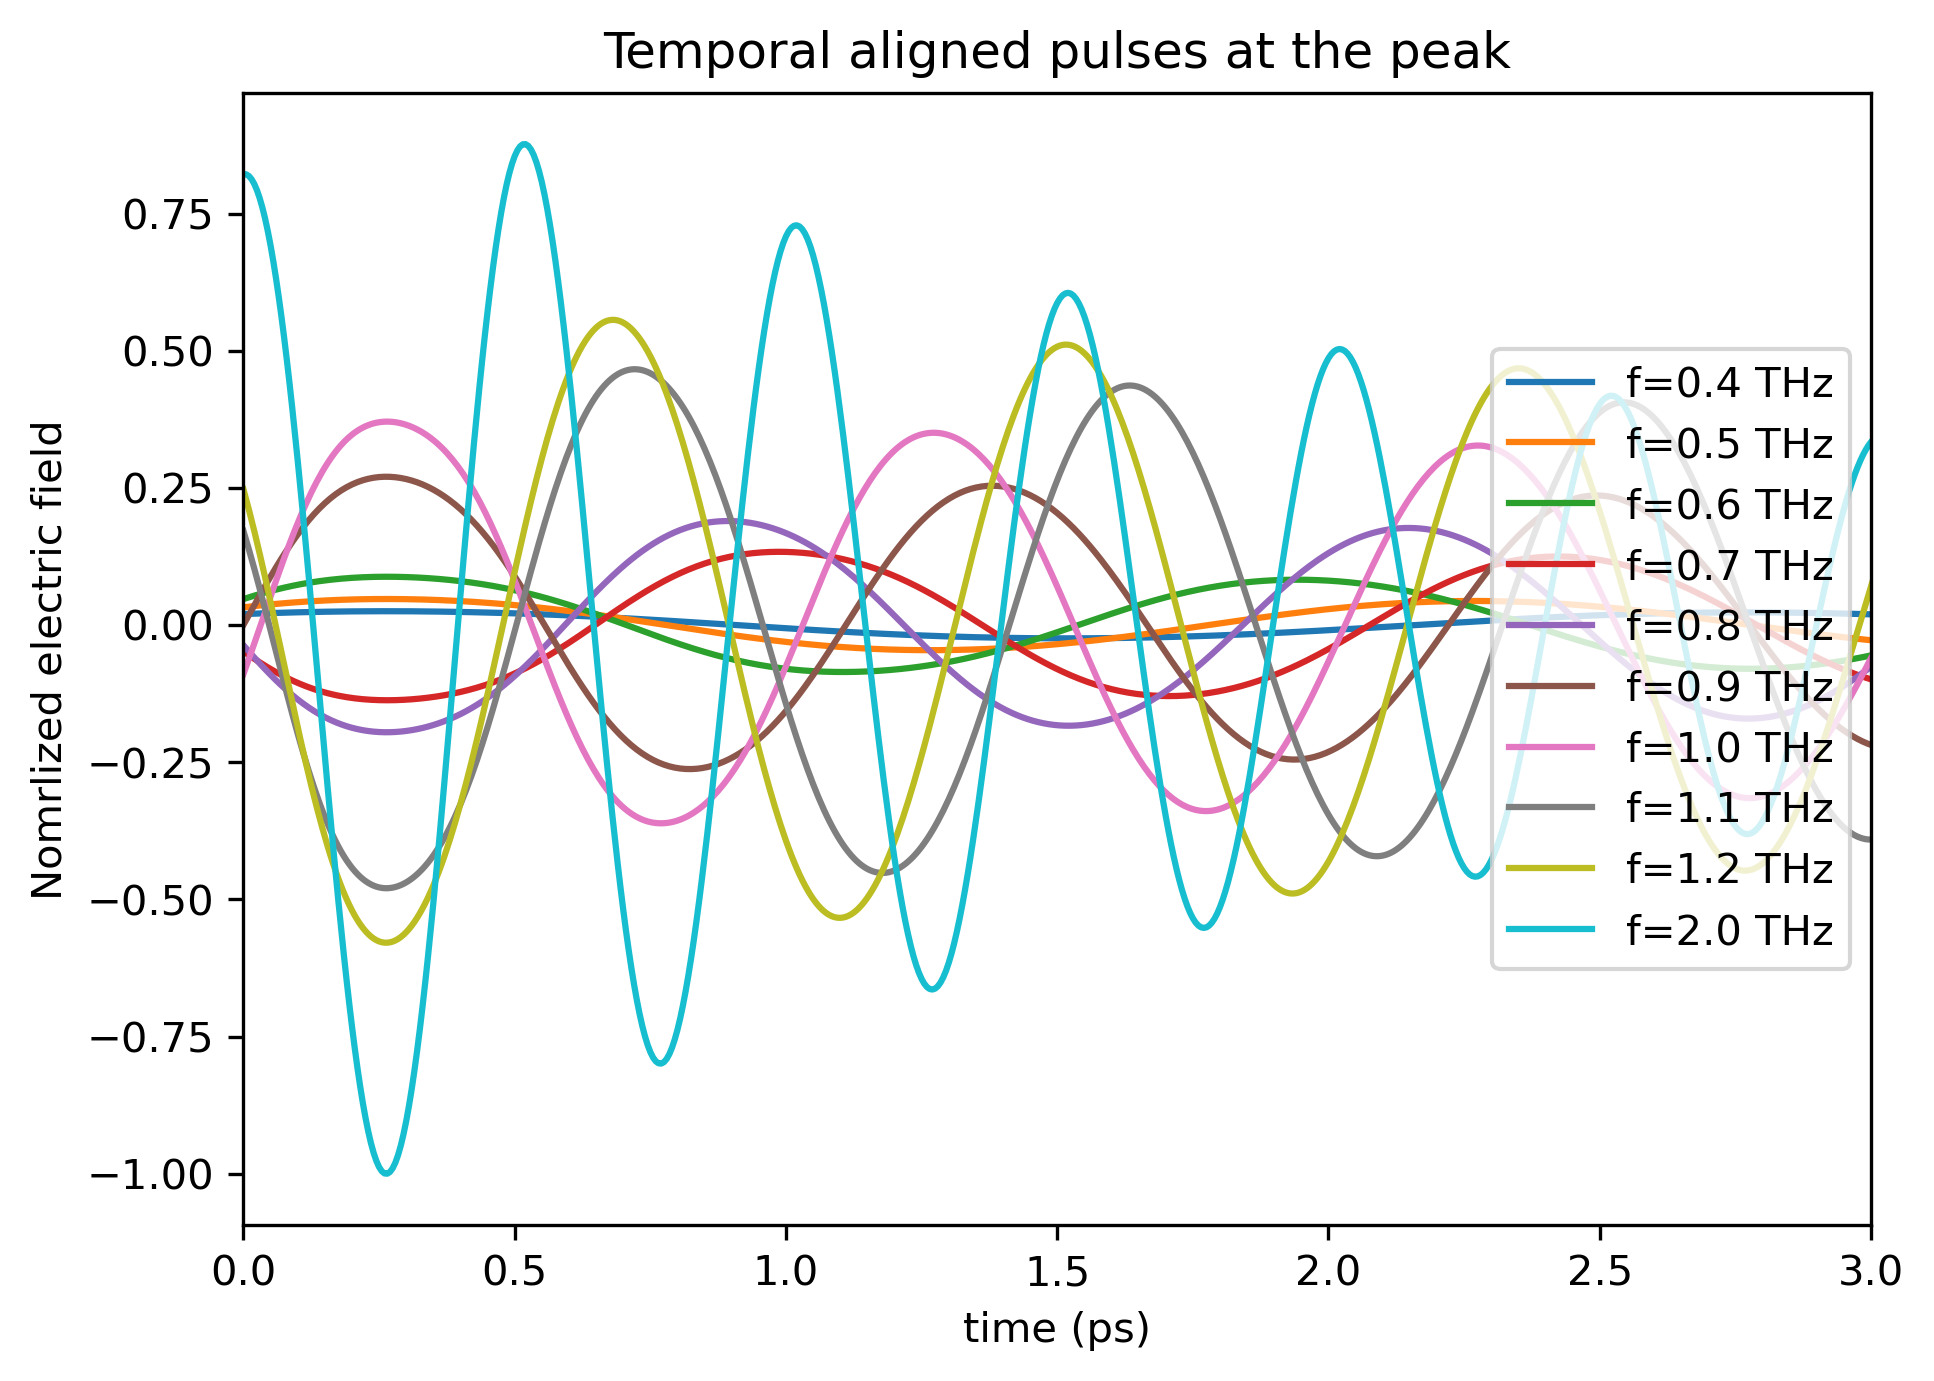

In [17]:
plt.figure(figsize=(7, 5), dpi=300)
plt.xlim([0, 3])
plt.title('Temporal aligned pulses at the peak')
plot_pulses(pulses)
plt.savefig("alighned_pulses.pdf", transparent=True)
plt.show()

In [13]:
# Finding optimal strategies for generating supperoscilations via SVD
U, sigmas, Vh = svd(pulses[:observational_window], full_matrices=False)

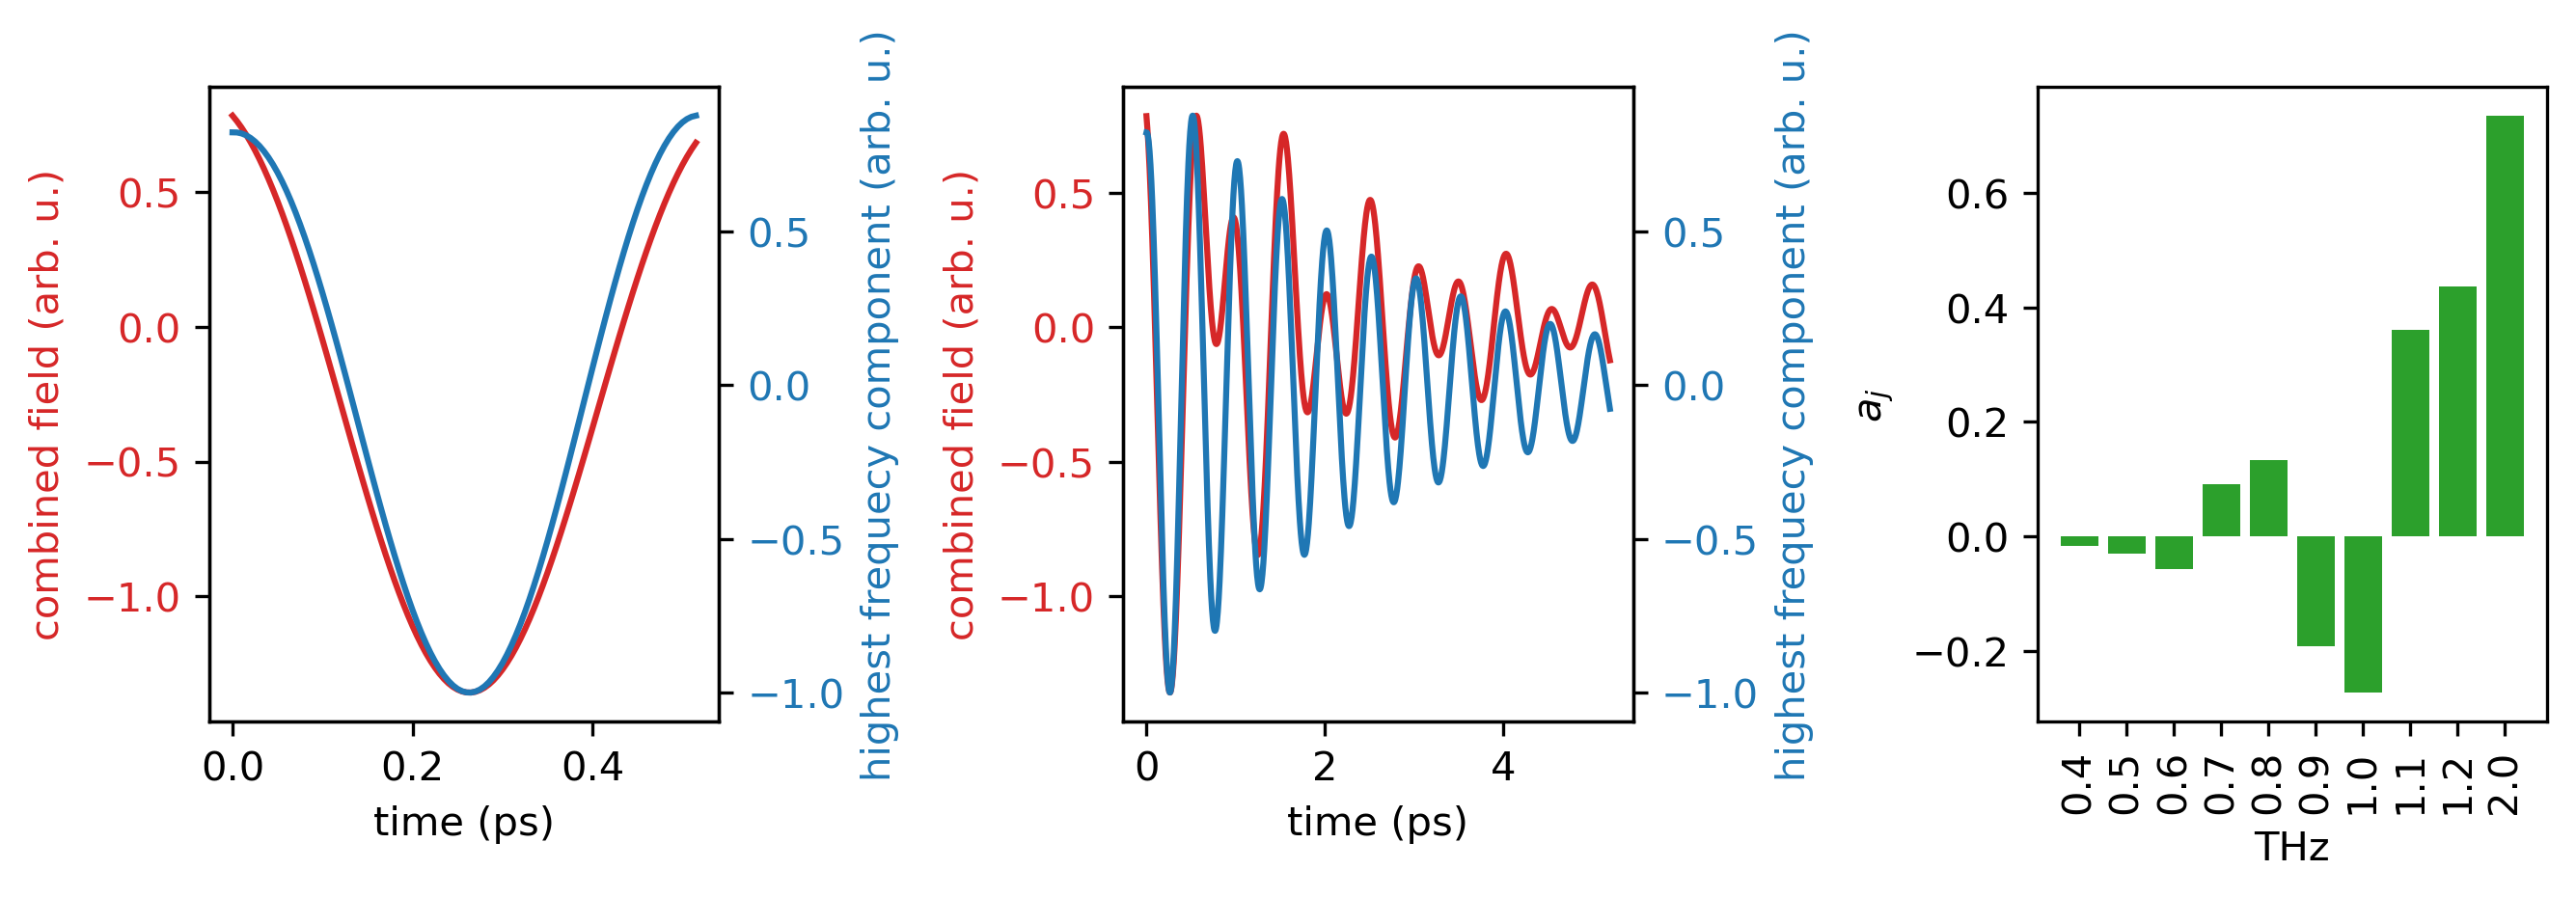

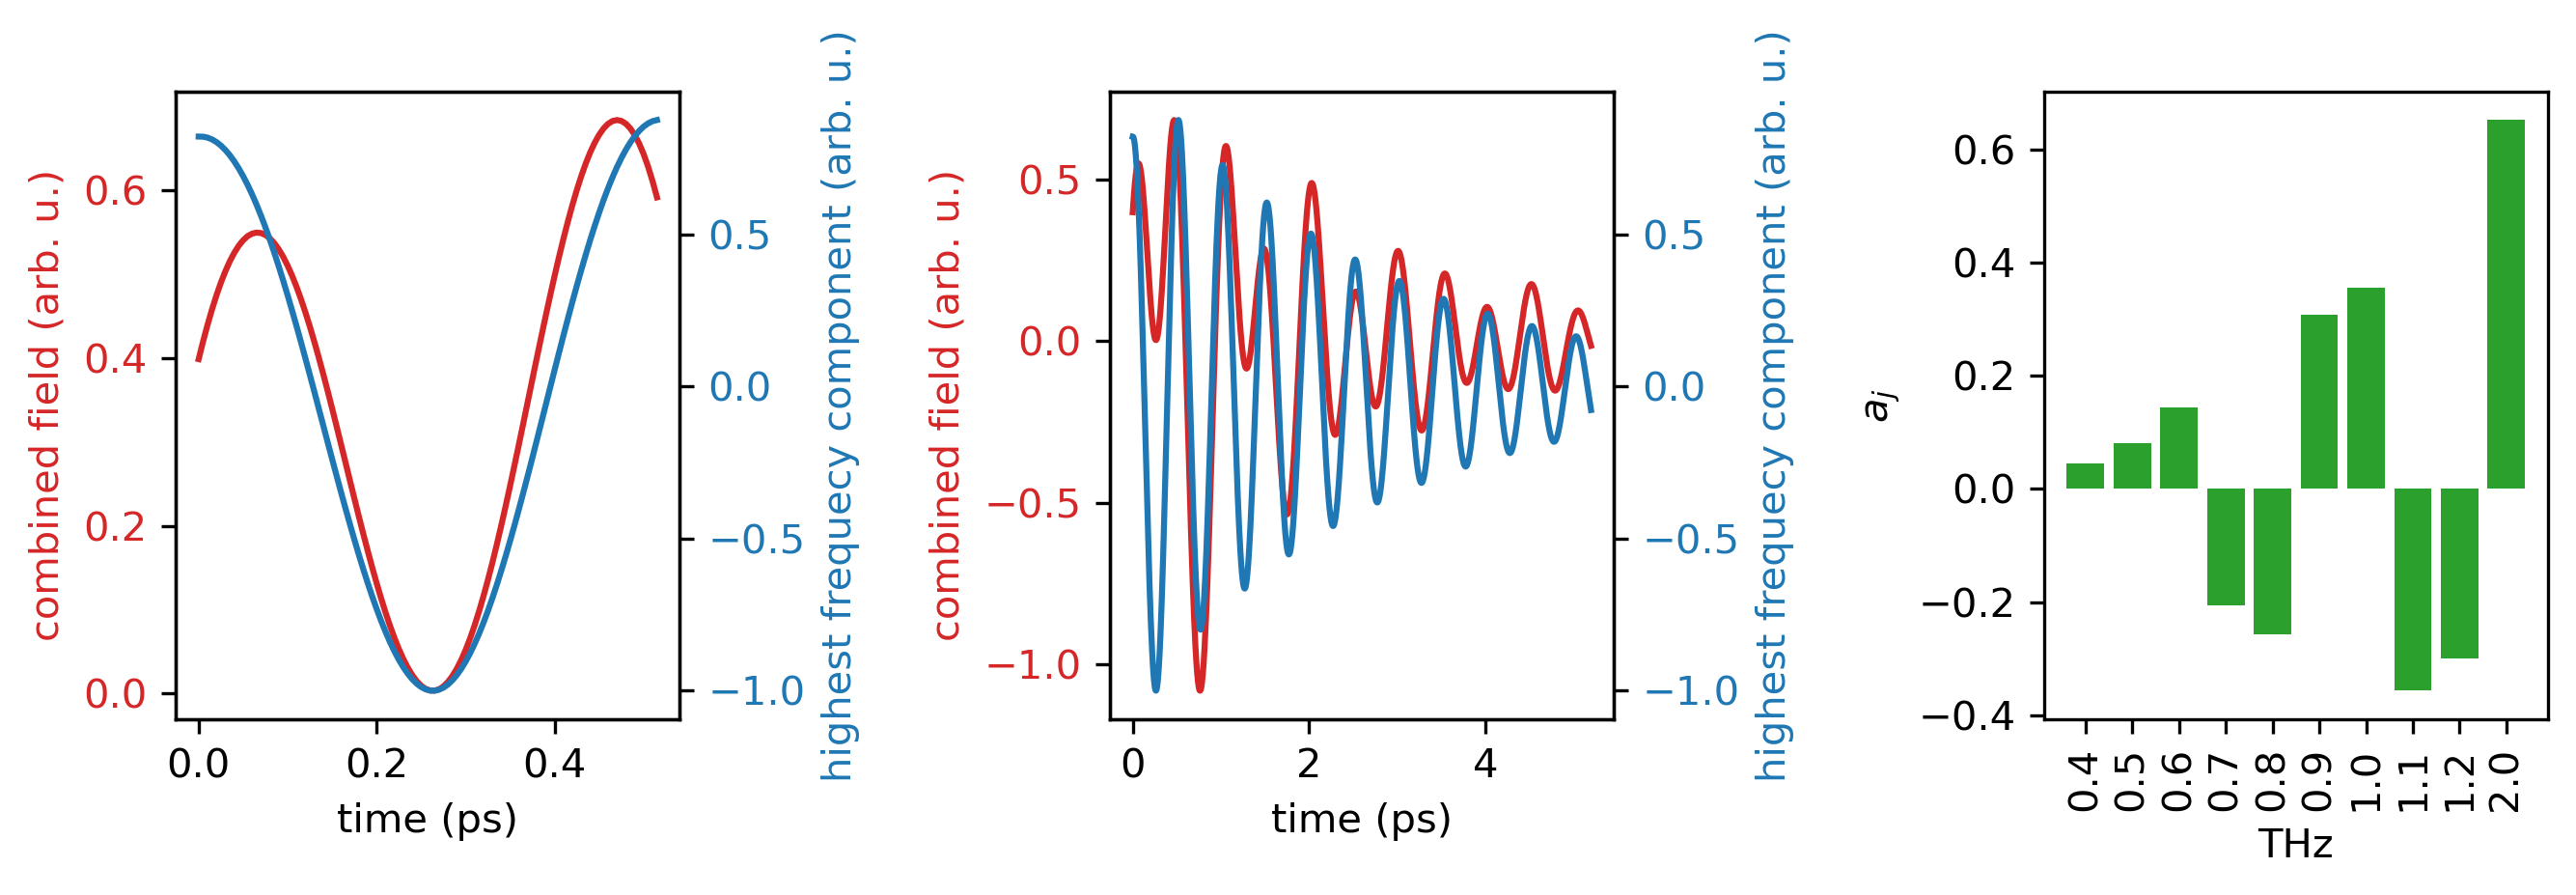

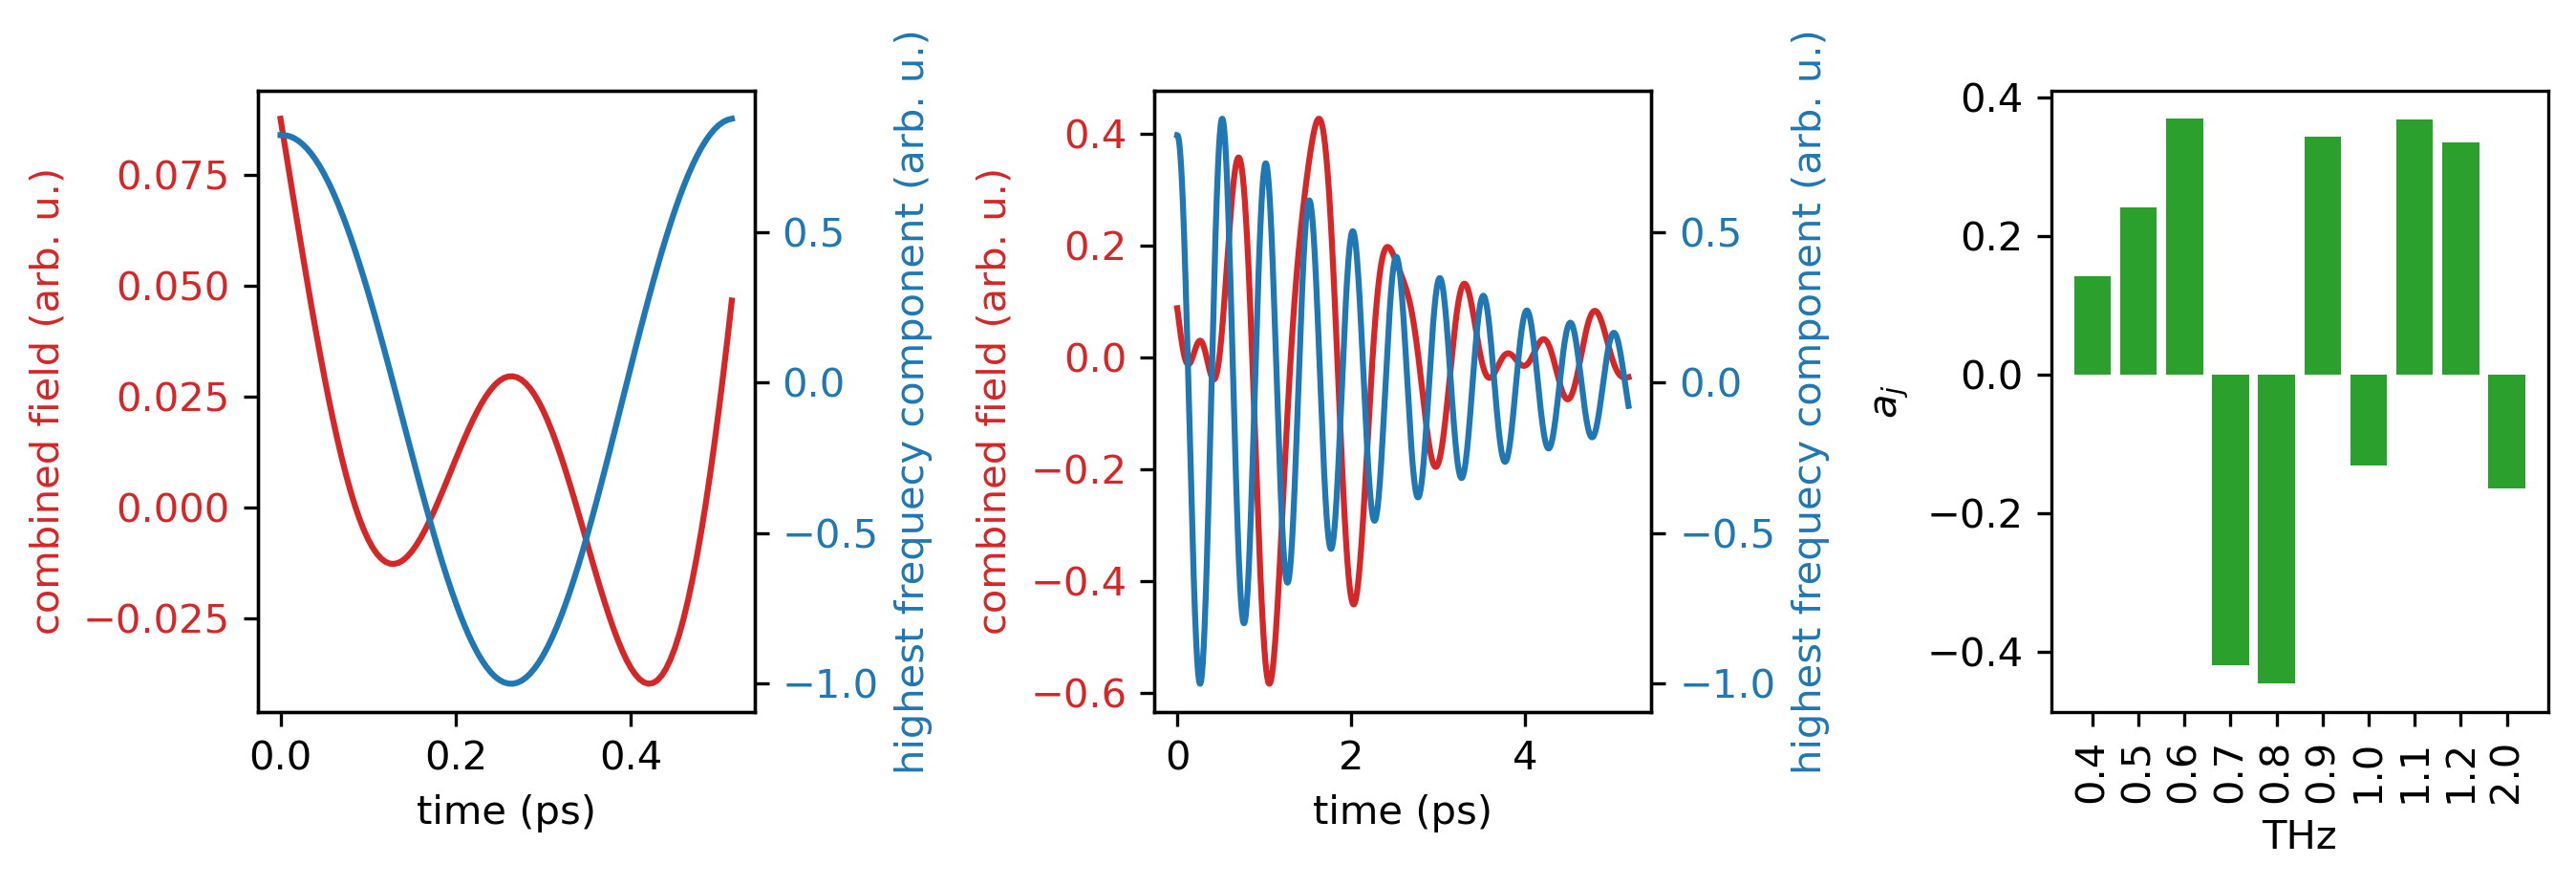

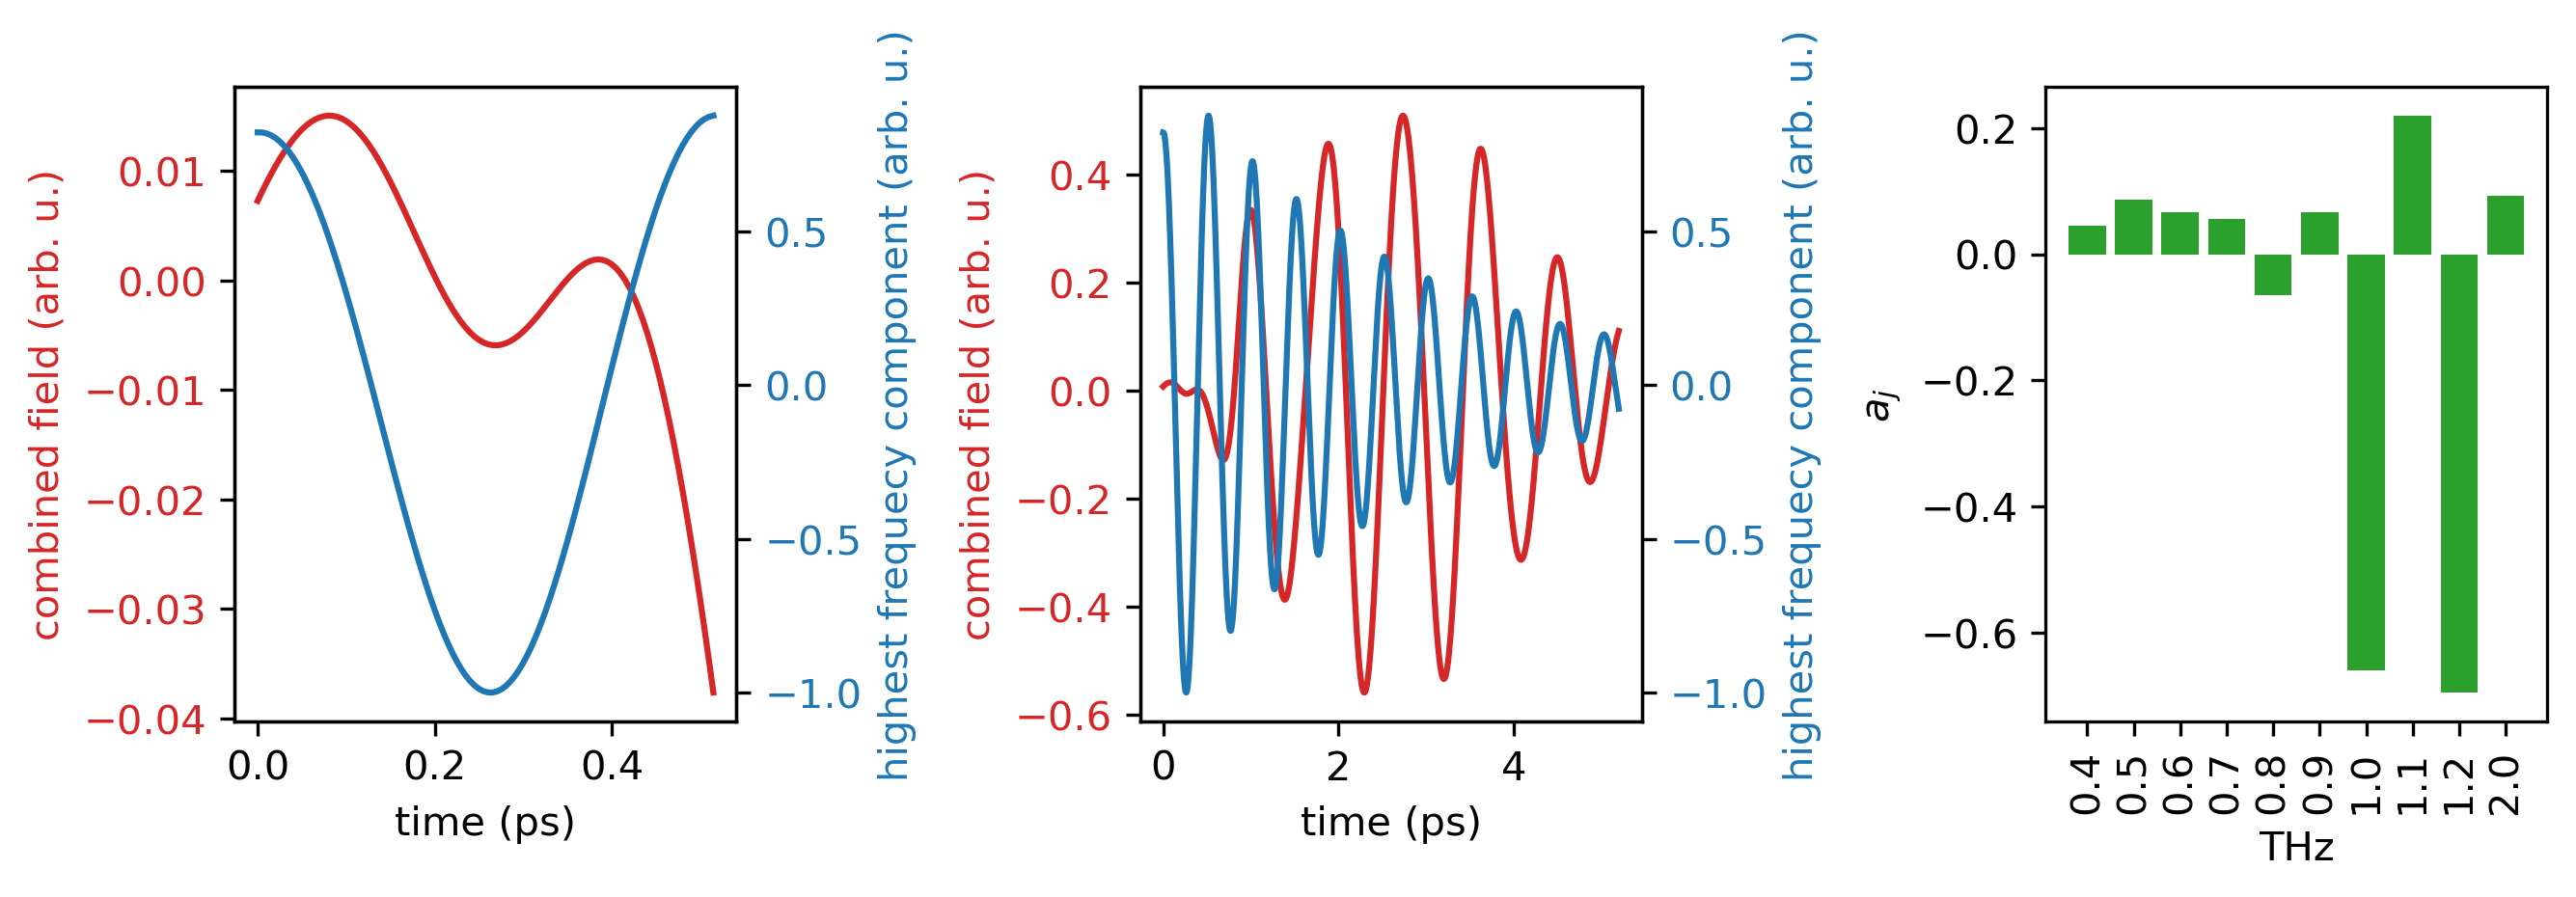

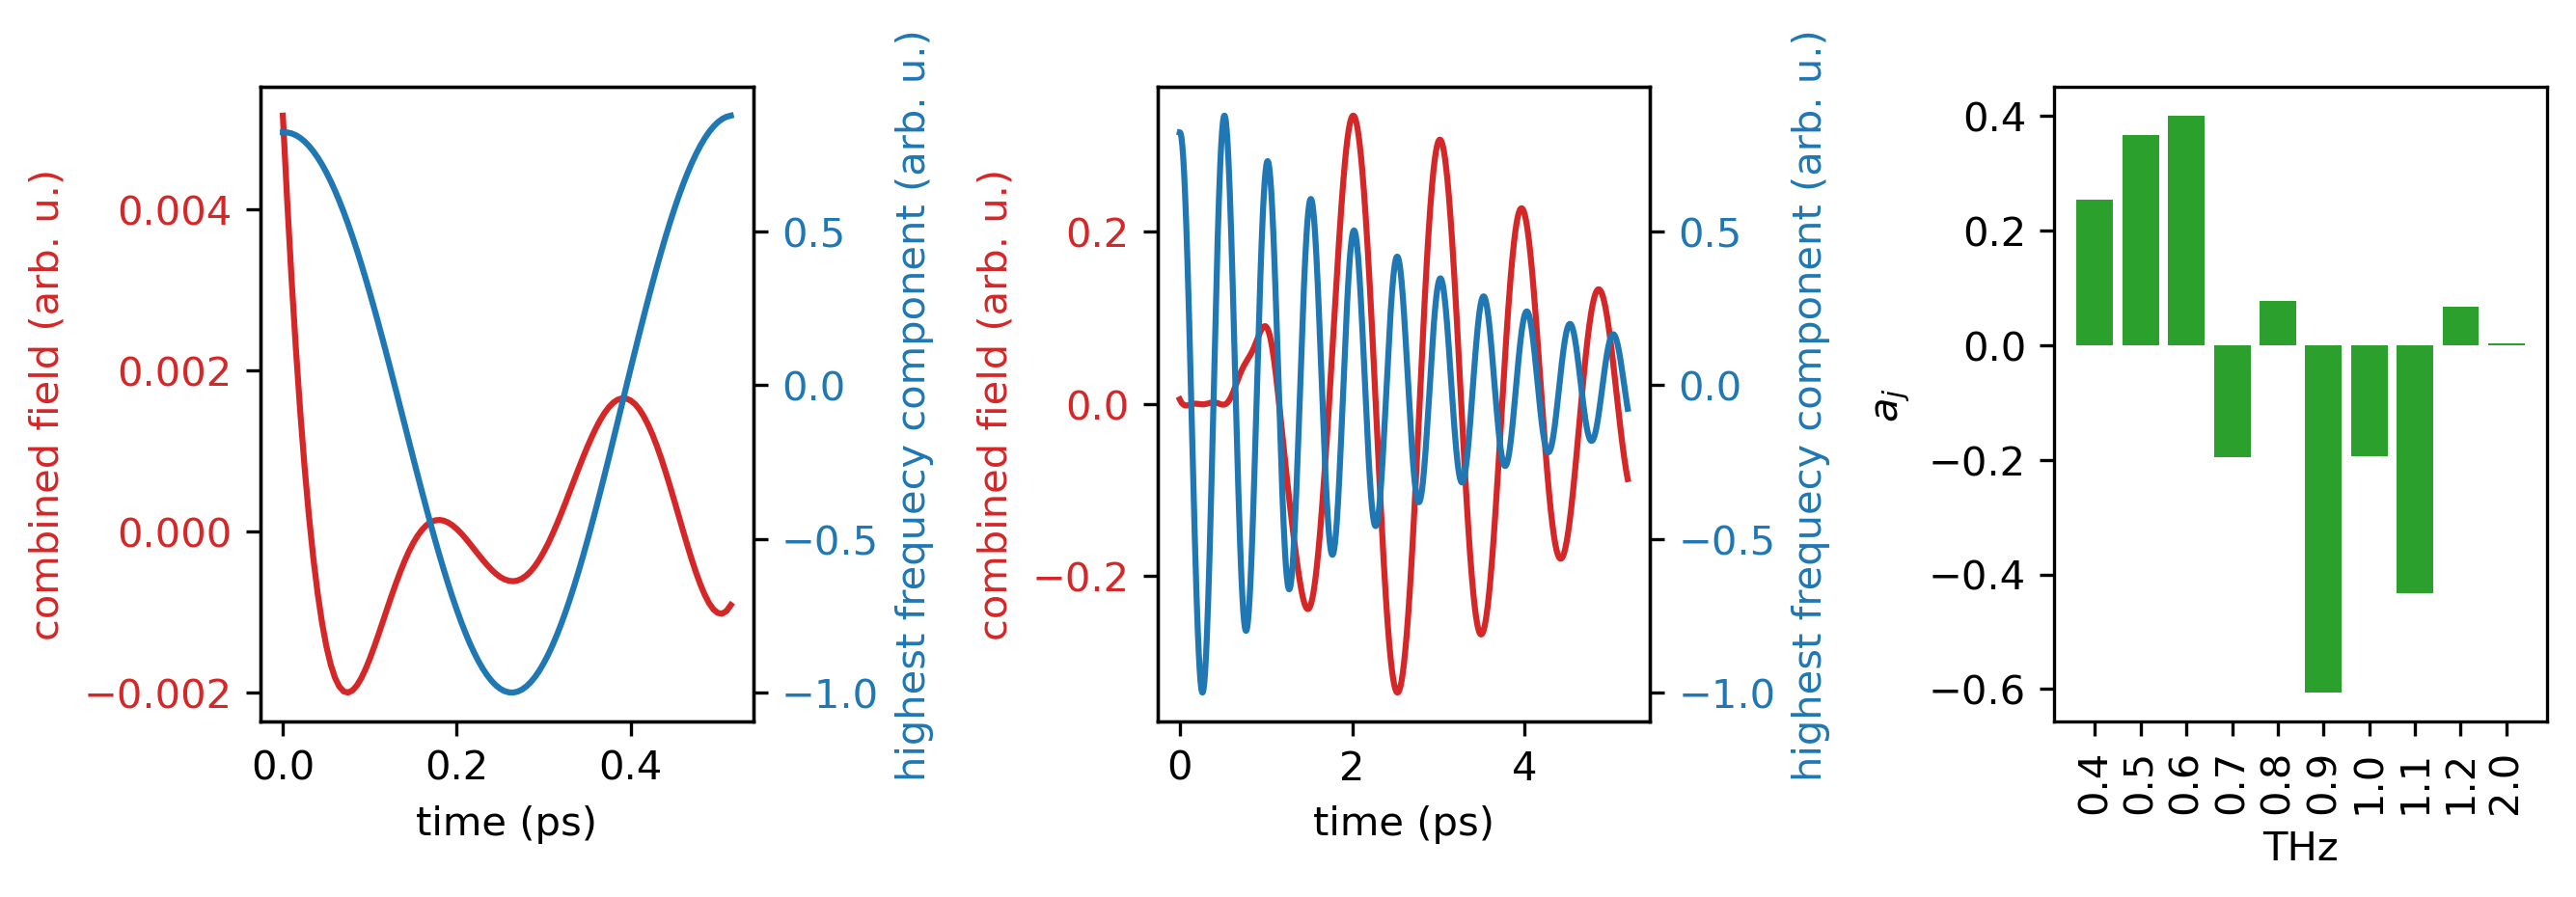

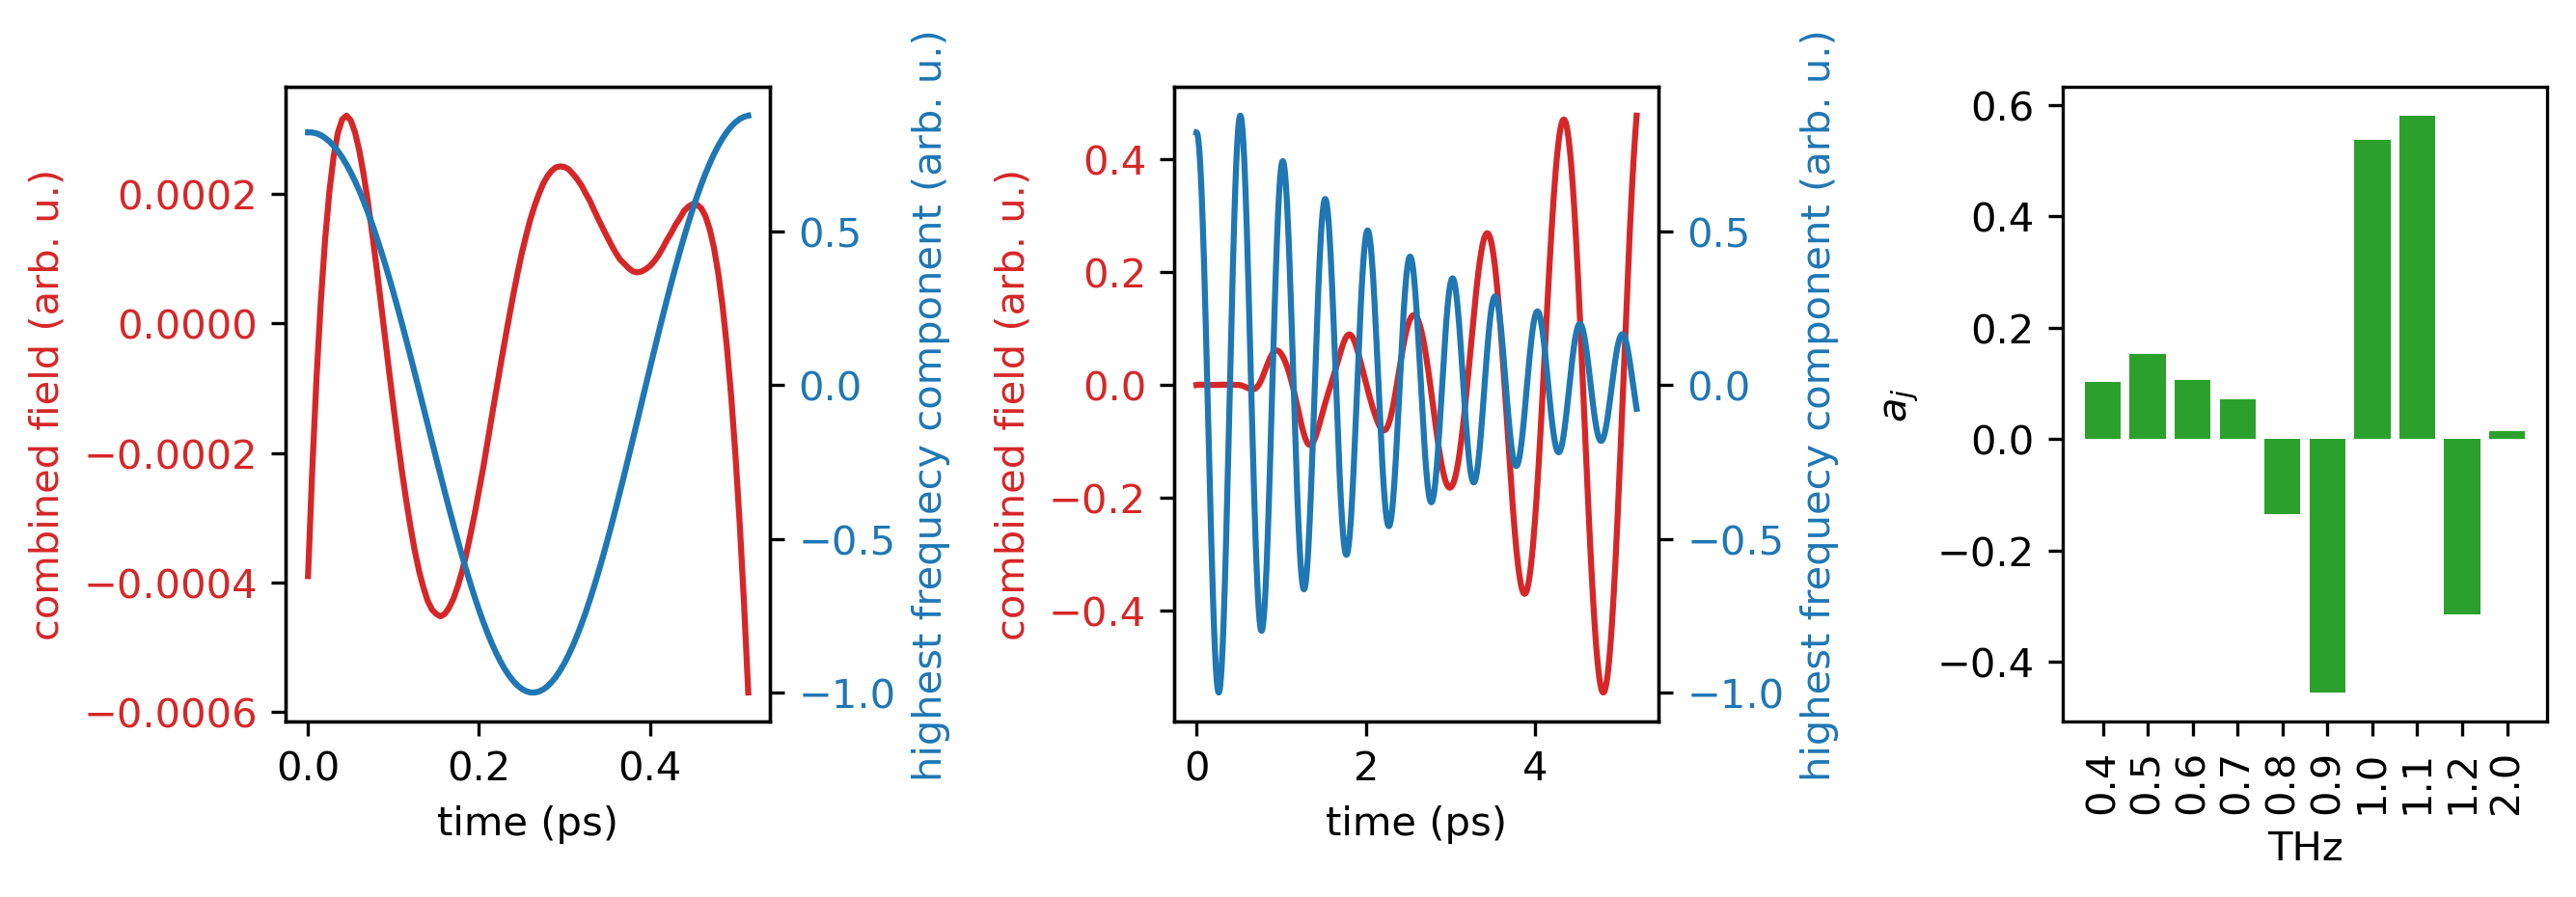

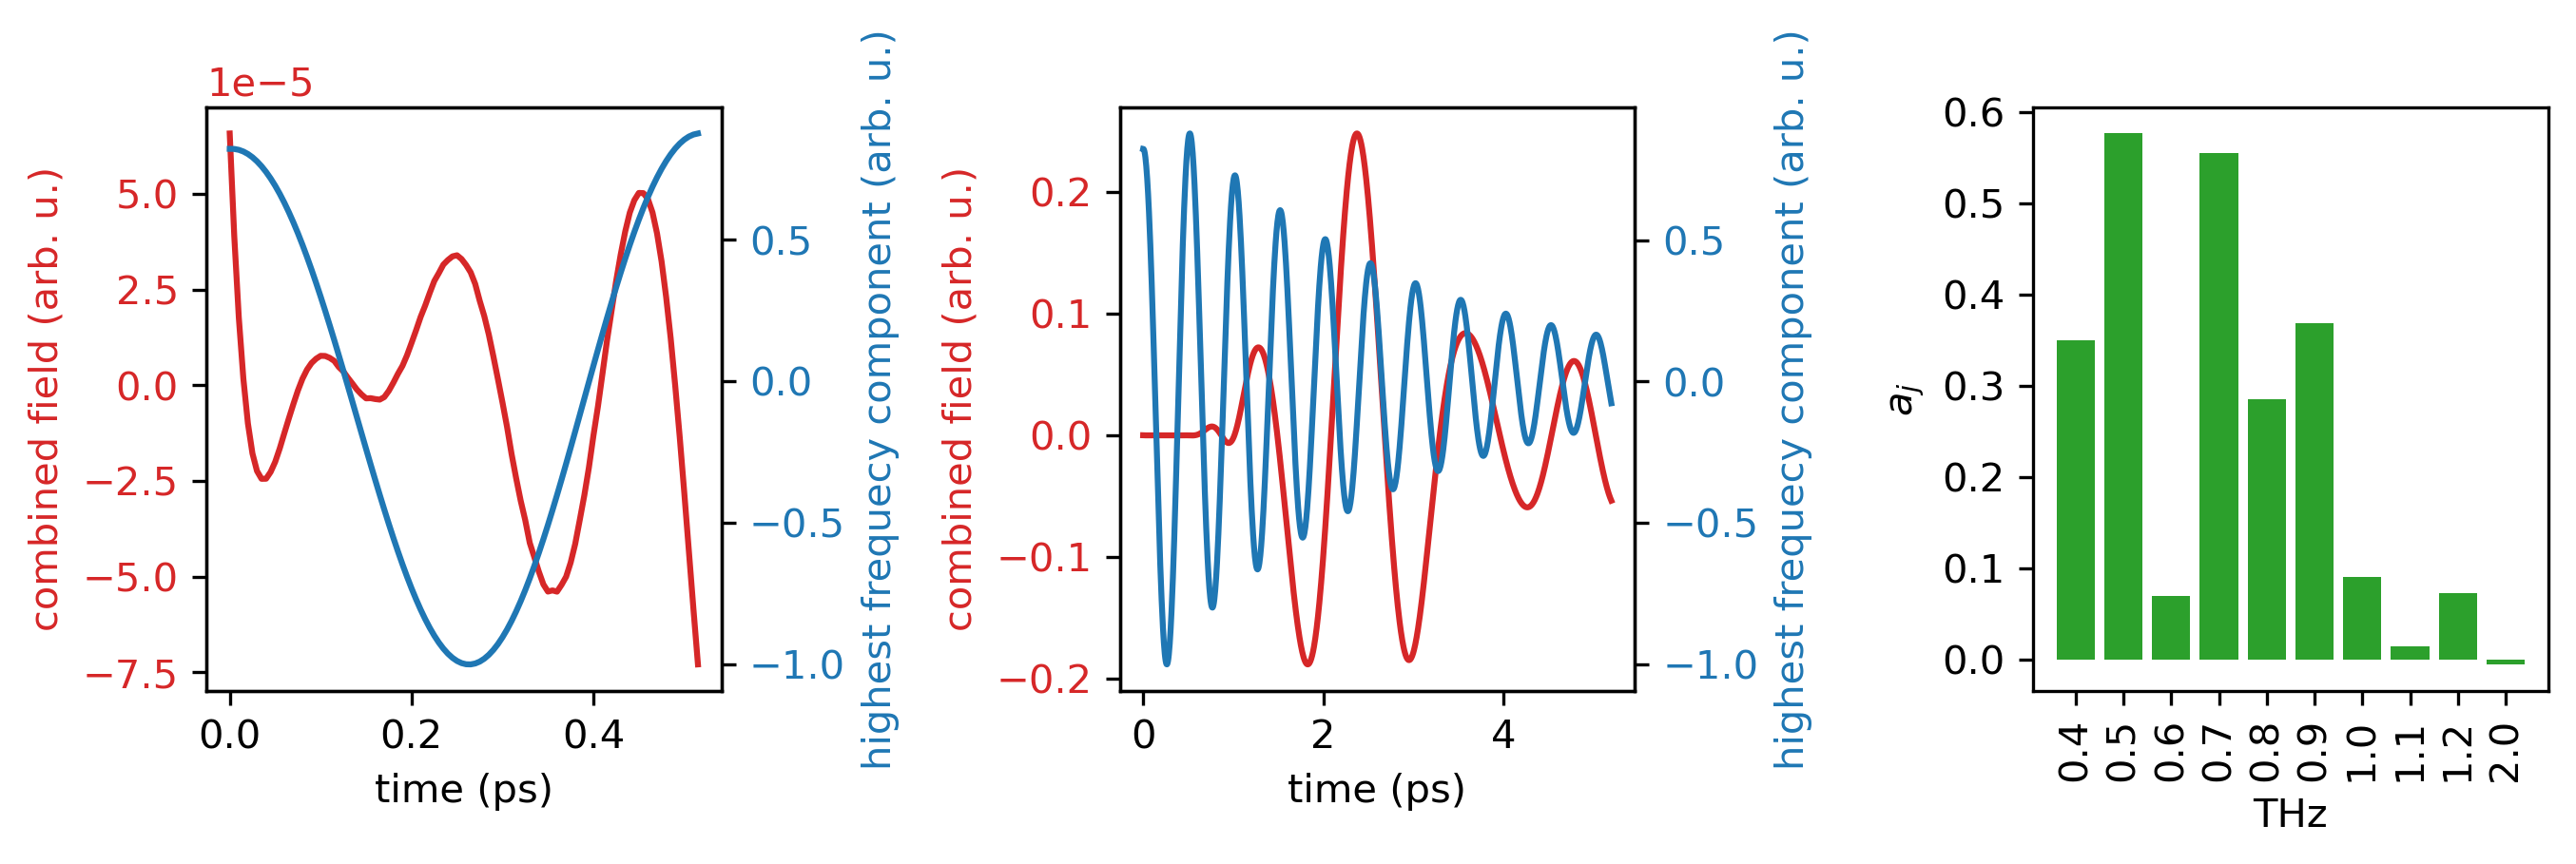

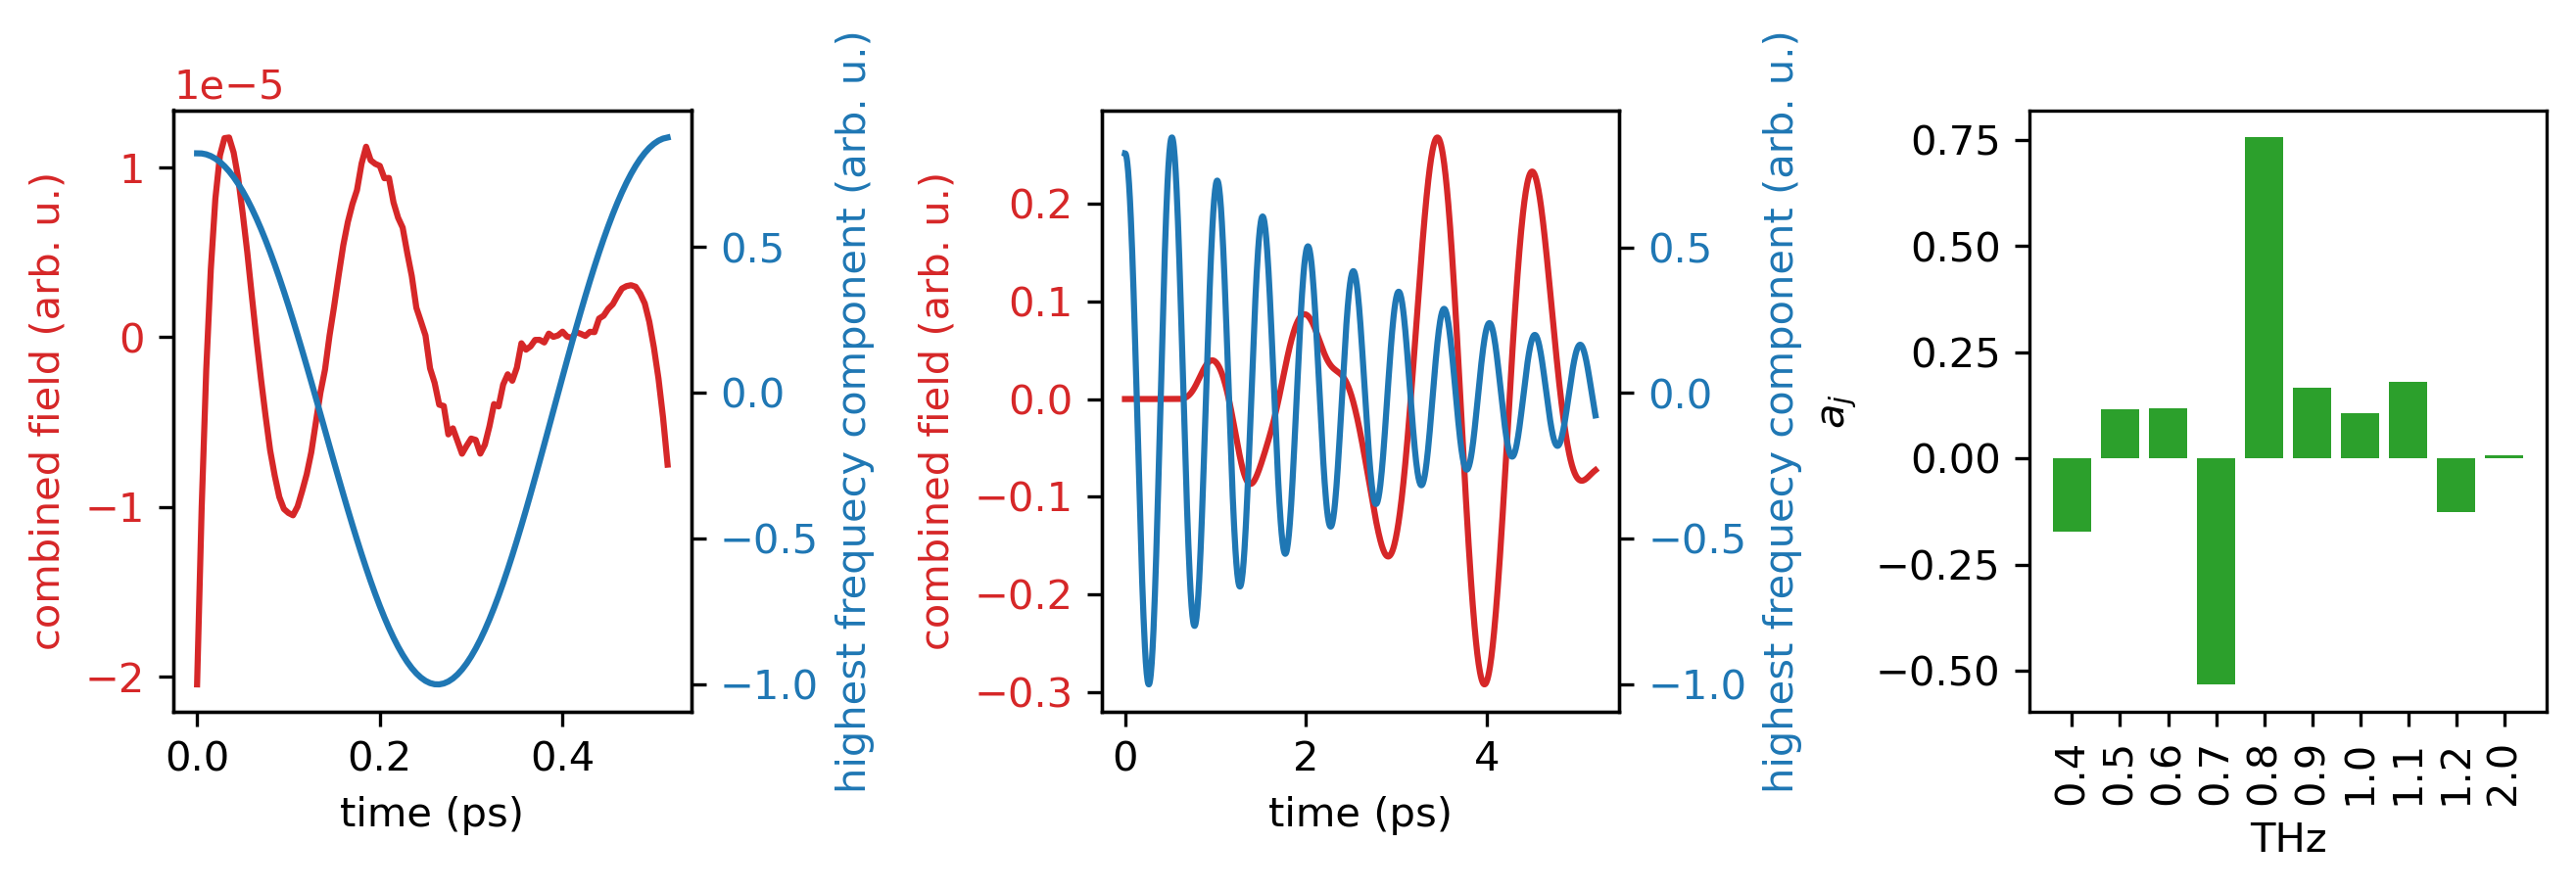

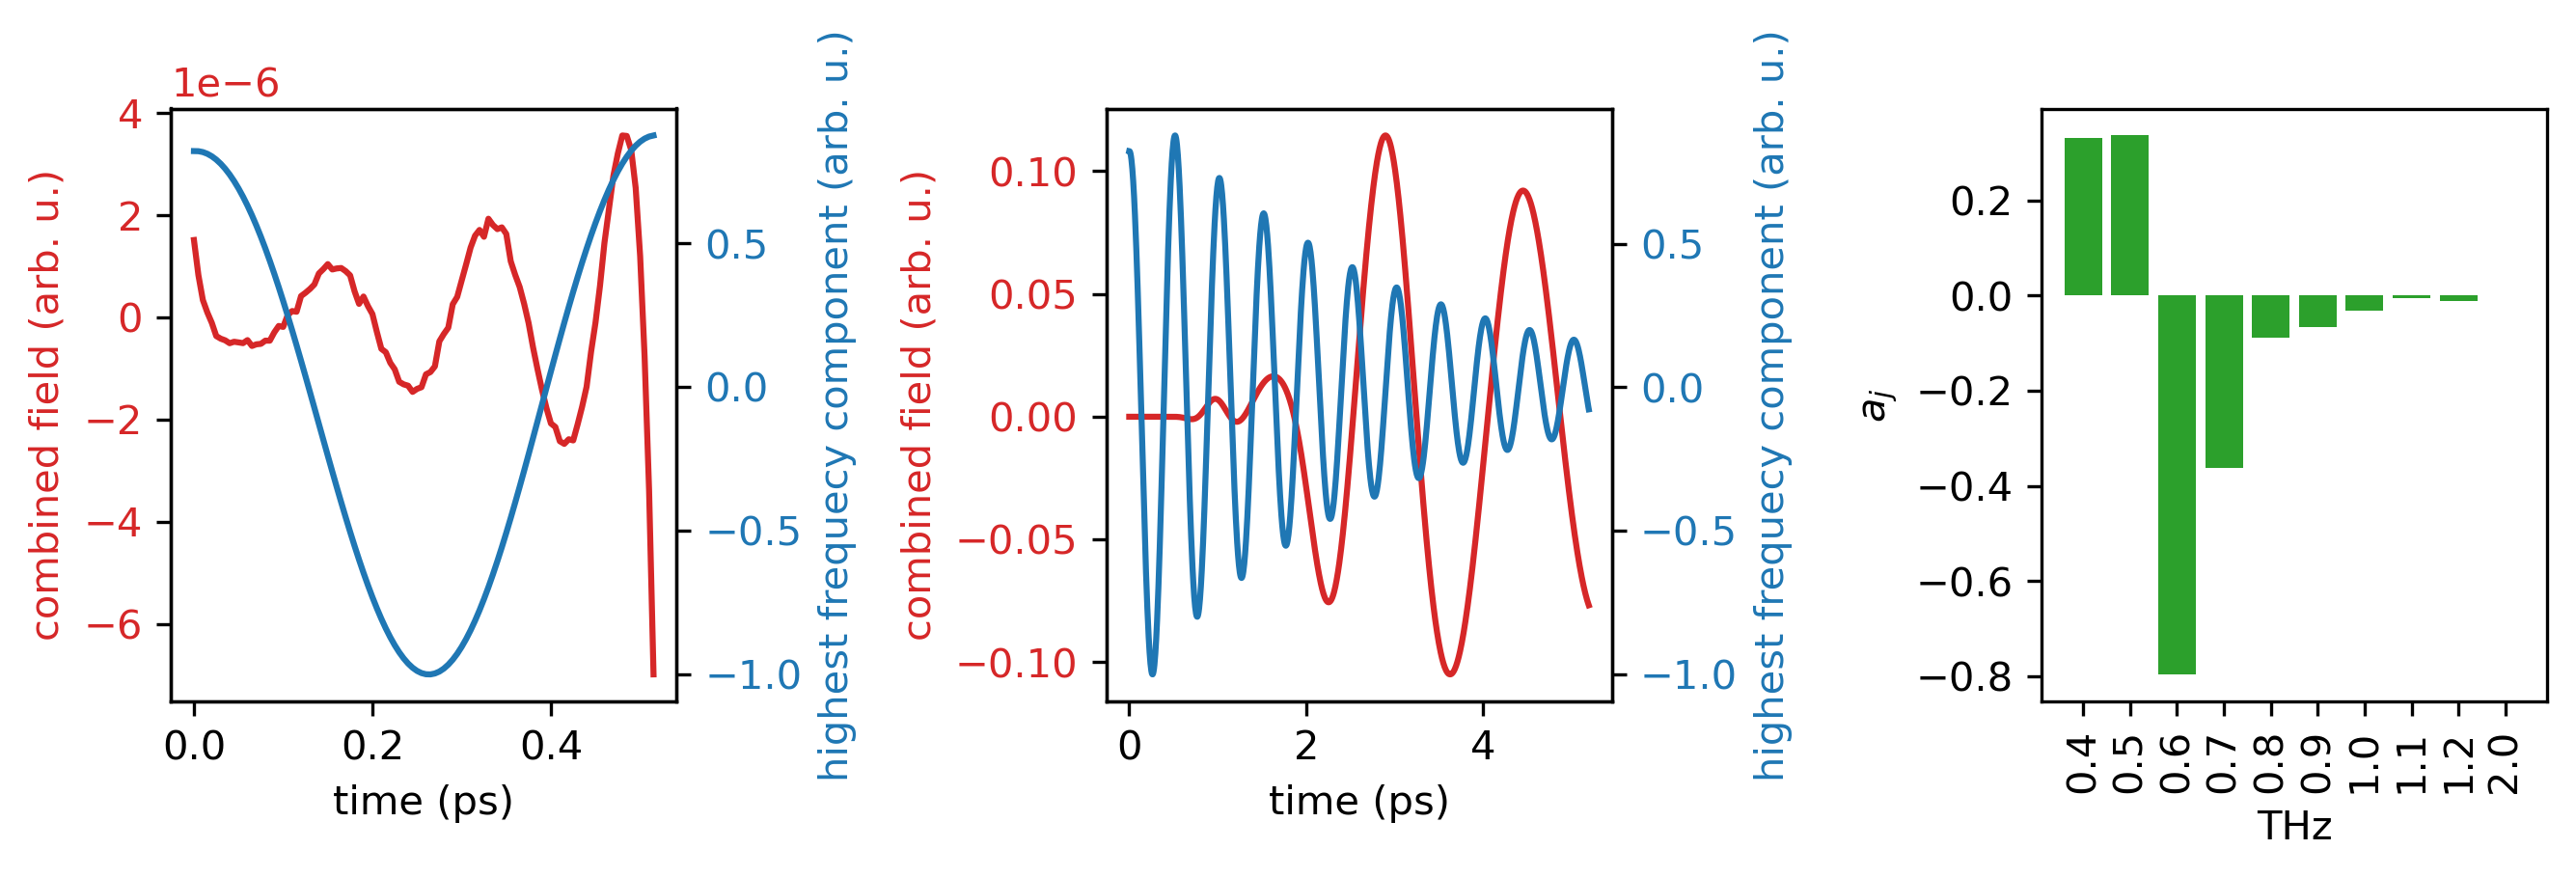

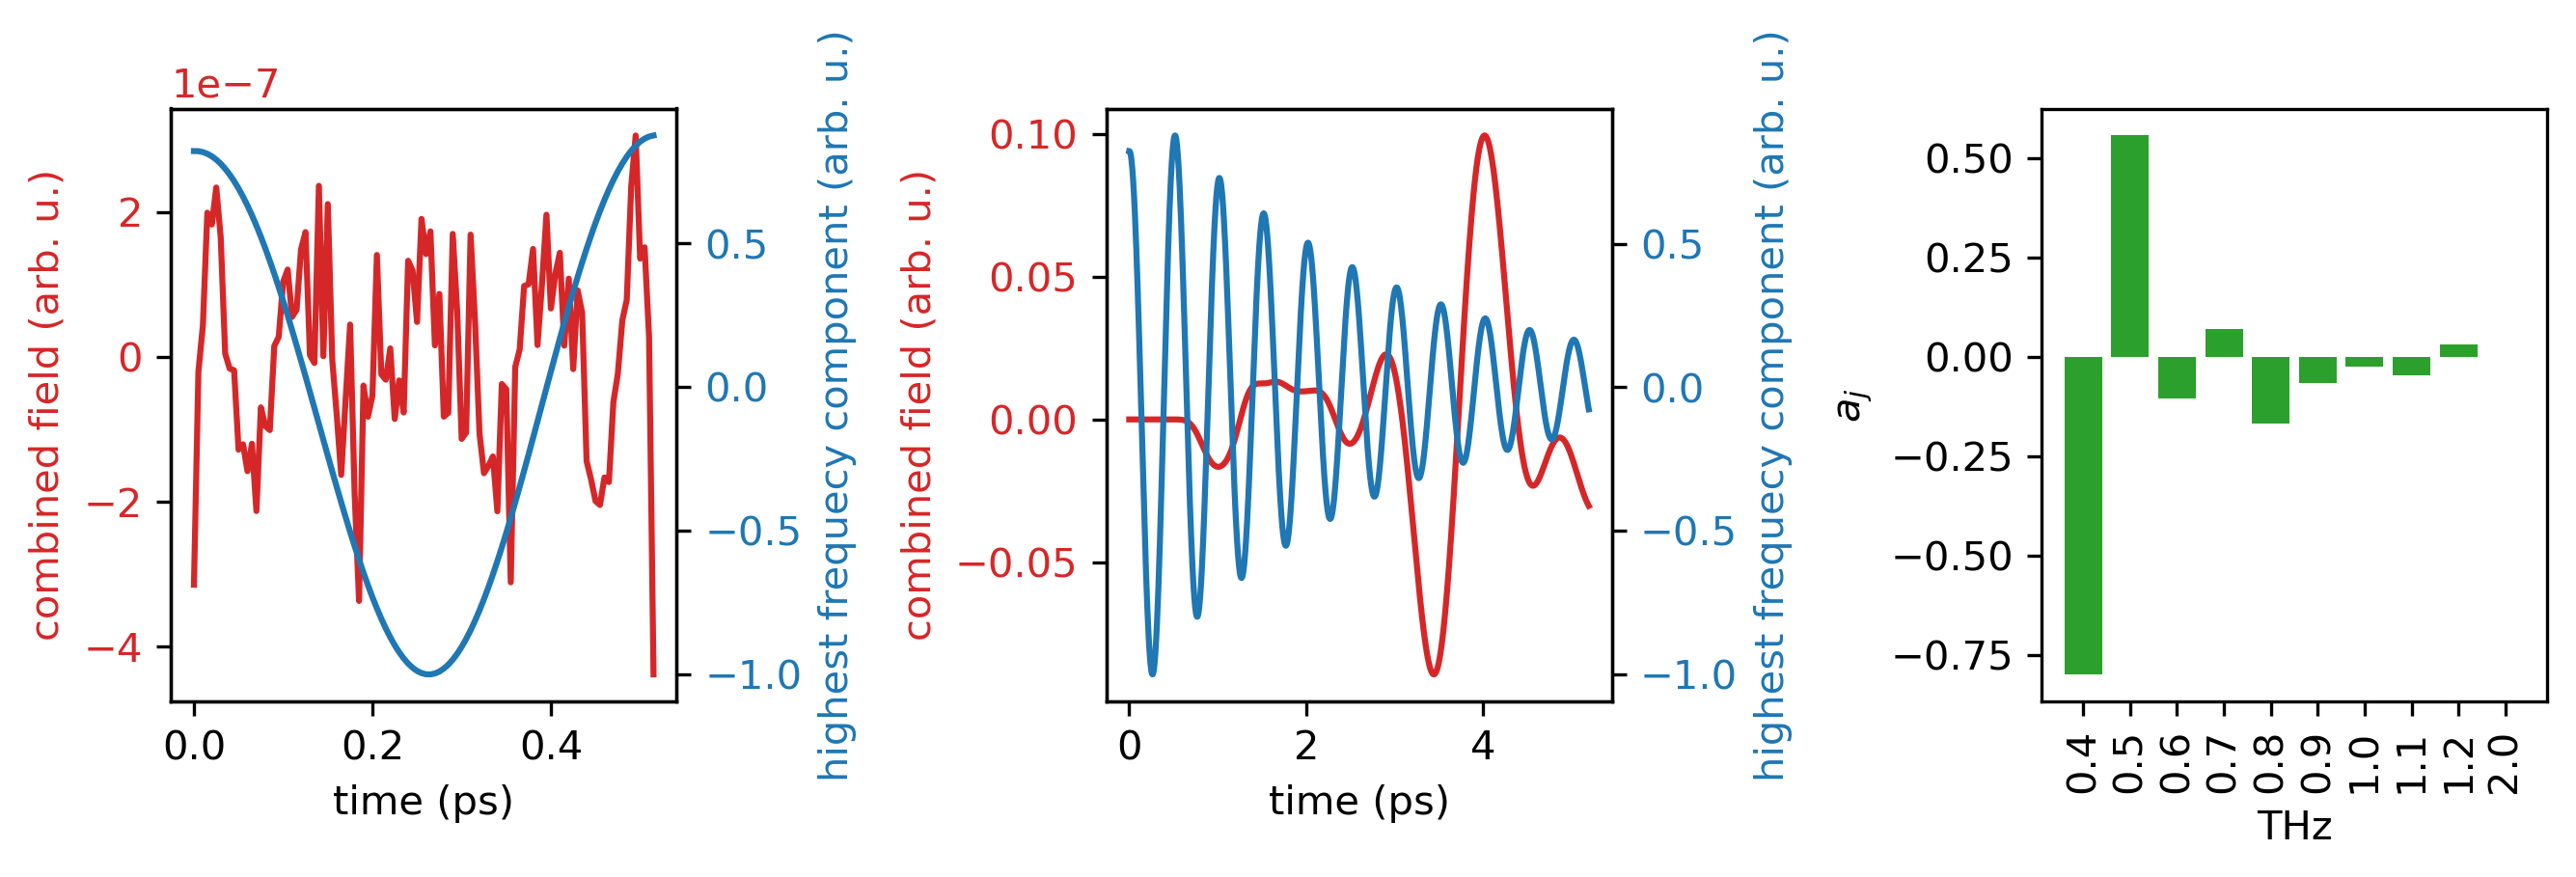

In [24]:
largest_freq_pulse = pulses[largest_freq]


for num, singular_vector in enumerate(Vh):
    
    # get superoscilating fields
    field = pulses @ singular_vector
    
    # a sanity check
    assert np.allclose(np.linalg.norm(singular_vector), 1.)
    
    # plot zoom in view
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
    
    color1 = 'tab:red'
    ax1.set_ylabel('combined field (arb. u.)', color=color1)
    ax1.plot(times[:observational_window], field[:observational_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('highest frequecy component (arb. u.)', color=color2)
    ax2.plot(times[:observational_window], largest_freq_pulse[:observational_window], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot zoom out view
    larger_window = 10 * observational_window
    
    ax1 = ax1_
    
    ax1.set_ylabel('combined field (arb. u.)', color=color1)
    ax1.plot(times[:larger_window], field[:larger_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (arb. u.)', color=color2)
    ax2.plot(times[:larger_window], largest_freq_pulse[:larger_window])
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(singular_vector.size), singular_vector, color='tab:green')
    ax1.set_xticks(np.arange(singular_vector.size))
    ax1.set_xticklabels(omega, rotation='vertical')
    ax1.set_xlabel('THz')
    ax1.set_ylabel('$a_j$')
    
    fig.tight_layout()
    
    plt.savefig('fig_{}.pdf'.format(num), transparent=True)
    
    plt.show()